# 🏠 House Price Prediction using XGBoost
## 📘 Ames Housing Dataset

---

## 🧠 Prologue / Project Introduction

In this notebook, we’ll build a machine learning model to **predict house prices** using the **Ames Housing Dataset** and the **XGBoost** algorithm.

This dataset offers a rich set of features describing various aspects of residential homes in Ames, Iowa making it ideal for practicing **tabular data modeling**, **feature engineering**, and **model interpretation**.

XGBoost (Extreme Gradient Boosting) is a powerful, scalable tree boosting system used widely in real-world machine learning tasks. It supports parallel processing, regularization, and has built-in tools for handling missing values.

We will approach this project in 7 stages:

1. Load and explore the dataset
2. Preprocess the data
3. Train a baseline XGBoost model
4. Evaluate the model performance
5. Analyze feature importance
6. Tune hyperparameters for better performance
7. Explain individual predictions using SHAP values

Let’s begin


## 1. Load Dataset and Import Libraries

We start by importing essential libraries and loading the Ames Housing dataset.
We'll inspect the structure and basic shape of the data.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv('train.csv')  # pastikan file tersedia di direktori
print("✅ Dataset loaded.")
df.shape, df.head()


✅ Dataset loaded.


((1460, 81),
    Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
 0   1          60       RL         65.0     8450   Pave   NaN      Reg   
 1   2          20       RL         80.0     9600   Pave   NaN      Reg   
 2   3          60       RL         68.0    11250   Pave   NaN      IR1   
 3   4          70       RL         60.0     9550   Pave   NaN      IR1   
 4   5          60       RL         84.0    14260   Pave   NaN      IR1   
 
   LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
 0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
 1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
 2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
 3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
 4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   
 
   YrSold  SaleType  SaleCondition  SaleP

## 2. Data Cleaning and Preprocessing

To ensure that XGBoost can train efficiently, we need to:

- Remove unnecessary columns
- Handle missing values
- Encode categorical features


In [2]:
# Drop ID and target variable
X = df.drop(['Id', 'SalePrice'], axis=1)
y = df['SalePrice']

# One-hot encode categorical columns
X_encoded = pd.get_dummies(X)

# Fill missing values with median
X_encoded = X_encoded.fillna(X_encoded.median(numeric_only=True))

# Show the new shape after encoding
print(f"✅ Data shape after encoding: {X_encoded.shape}")


✅ Data shape after encoding: (1460, 287)


## 3. Split Data into Training and Testing Sets

We split the dataset into training and testing sets using an 80/20 ratio.

This ensures the model is evaluated on data it has never seen before, giving us a realistic measure of its performance.


In [3]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

print("✅ Training set size:", X_train.shape)
print("✅ Testing set size:", X_test.shape)


✅ Training set size: (1168, 287)
✅ Testing set size: (292, 287)


## 4. Train XGBoost Regressor

We now train our first XGBoost model on the cleaned and encoded training data.

This version uses default parameters with a few basic tuning options to balance performance and training time.


In [4]:
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)


## 5. Evaluate Model with RMSE Visualization

The chart below shows how the Root Mean Squared Error (RMSE) evolves as more trees (boosting rounds) are added.

- **Training RMSE** decreases consistently as the model learns from the training data.
- **Testing RMSE** also improves initially but starts to flatten after around 40–50 trees.

This pattern suggests that the model performs well and does not overfit excessively within 100 trees.

We can use this curve to determine the optimal number of trees before performance on the test set stops improving.


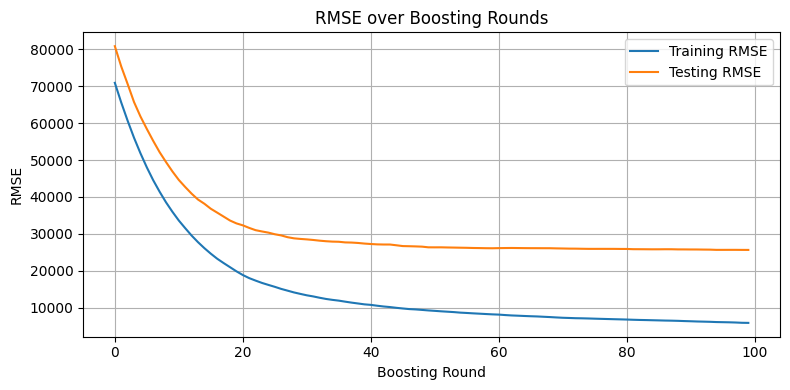

In [5]:
import matplotlib.pyplot as plt

# Fit and capture training history
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

# Access training log from booster
evals_result = xgb_model.evals_result()

# Extract RMSE values
train_rmse = evals_result['validation_0']['rmse']
test_rmse = evals_result['validation_1']['rmse']

# Plot
plt.figure(figsize=(8, 4))
plt.plot(train_rmse, label='Training RMSE')
plt.plot(test_rmse, label='Testing RMSE')
plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
plt.title('RMSE over Boosting Rounds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 6. Predict House Price for a Single Data Point

Let’s test the trained XGBoost model by predicting the price of the first house in our test set.

We'll compare the predicted value to the actual sale price.


In [6]:
# Select first house from the test set
sample = X_test.iloc[[0]]
actual_price = y_test.iloc[0]

# Predict using XGBoost model
predicted_price = xgb_model.predict(sample)[0]

print(f"🟡 Actual price   : ${actual_price:,.2f}")
print(f"🔵 Predicted price: ${predicted_price:,.2f}")


🟡 Actual price   : $154,500.00
🔵 Predicted price: $144,173.50


## 7. Visualize Prediction Accuracy

We compare predicted prices to actual sale prices using:

- A table for the first 10 test samples
- A scatter plot for the full test set

The red dashed line in the plot represents perfect prediction.  
Points close to the line indicate high accuracy.


In [7]:
# Predict the first 10 test samples
y_pred_10 = xgb_model.predict(X_test.iloc[:10])
y_true_10 = y_test.iloc[:10].values

# Create a DataFrame to compare
comparison_df = pd.DataFrame({
    'Actual Price': y_true_10,
    'Predicted Price': y_pred_10,
    'Error': y_true_10 - y_pred_10
})

# Round the values for better readability
comparison_df = comparison_df.round(2)
comparison_df


,Actual Price,Predicted Price,Error
0,154500,144173.500000,10326.50
1,325000,338594.593750,-13594.59
2,115000,115537.453125,-537.45
3,159000,159166.187500,-166.19
4,315500,311346.875000,4153.12
5,75500,86018.710938,-10518.71
6,311500,234017.406250,77482.61
7,146000,146042.031250,-42.03
8,84500,86128.046875,-1628.05
9,135500,122766.351562,12733.65


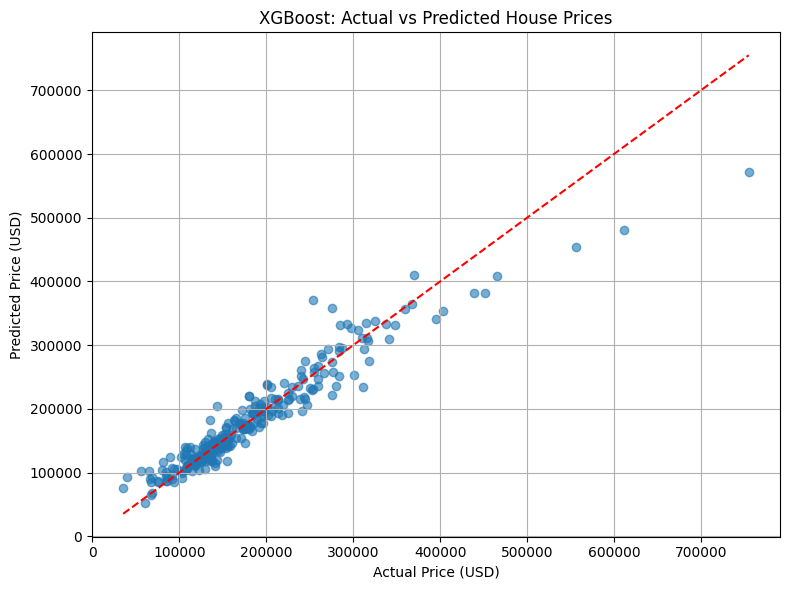

In [8]:
# Predict entire test set
y_pred_full = xgb_model.predict(X_test)

# Scatter plot: actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_full, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # ideal line
plt.xlabel('Actual Price (USD)')
plt.ylabel('Predicted Price (USD)')
plt.title('XGBoost: Actual vs Predicted House Prices')
plt.grid(True)
plt.tight_layout()
plt.show()


## 8. SHAP: Explain Individual Predictions

We use SHAP to understand which features influenced the model’s prediction for a specific house.


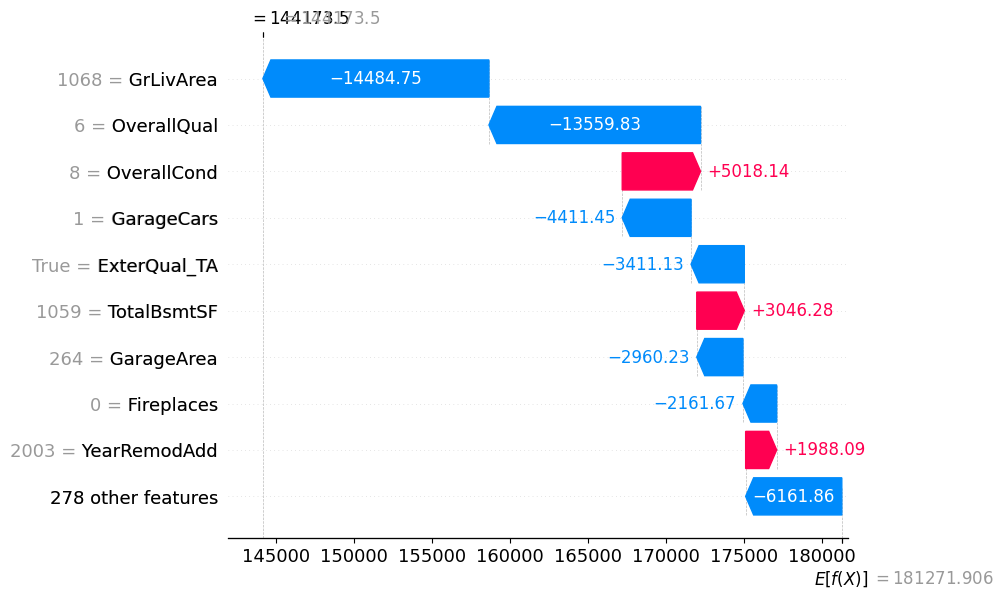

In [10]:
import shap

# Initialize JS visualizer (only in Jupyter Notebook, not needed in scripts)
shap.initjs()

# Create SHAP explainer for the XGBoost model
explainer = shap.Explainer(xgb_model)

# Compute SHAP values for a sample
shap_values = explainer(X_test)

# Visualize SHAP values for the first prediction
shap.plots.waterfall(shap_values[0])


SHAP helps us understand how each feature contributed to the final predicted price.

- The base value of the model was approximately $181,271 (average across all houses).
- `GrLivArea` and `OverallQual` were the strongest contributors that pushed the predicted price downward.
- Positive contributions from `OverallCond`, `TotalBsmtSF`, and `YearRemodAdd` partially offset the negative effects.

This visualization gives a transparent, feature-by-feature breakdown of how the model "thinks."


## 9. SHAP Summary Plot

The SHAP summary plot shows the most influential features across the entire test set.  
It combines both feature importance and the direction of impact (positive or negative).


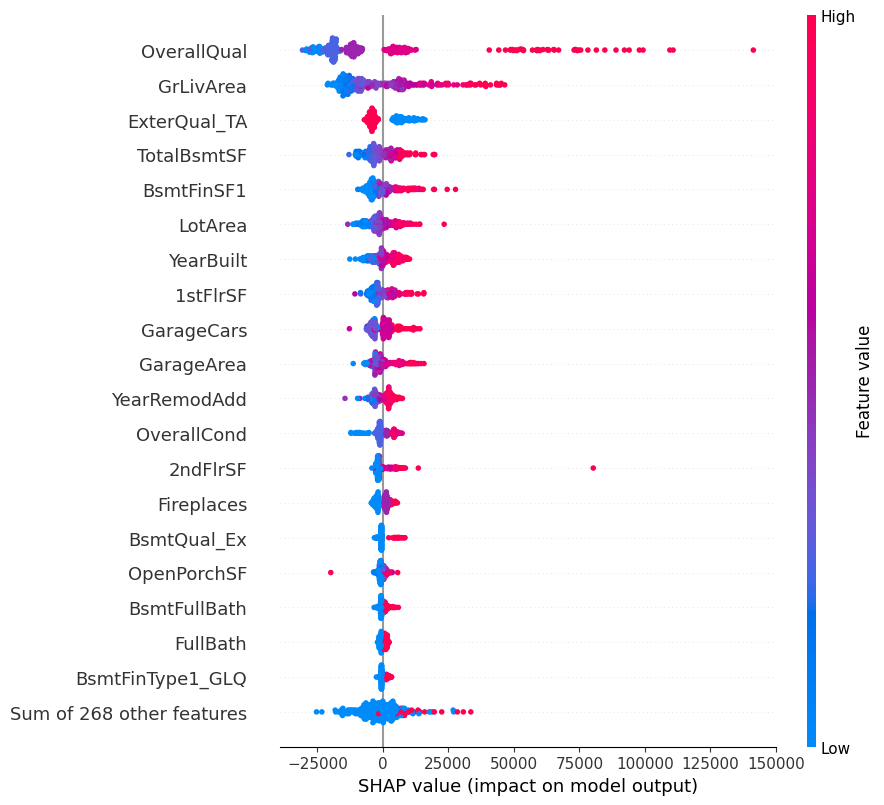

In [11]:
# Show global feature importance with SHAP summary plot
shap.plots.beeswarm(shap_values, max_display=20)


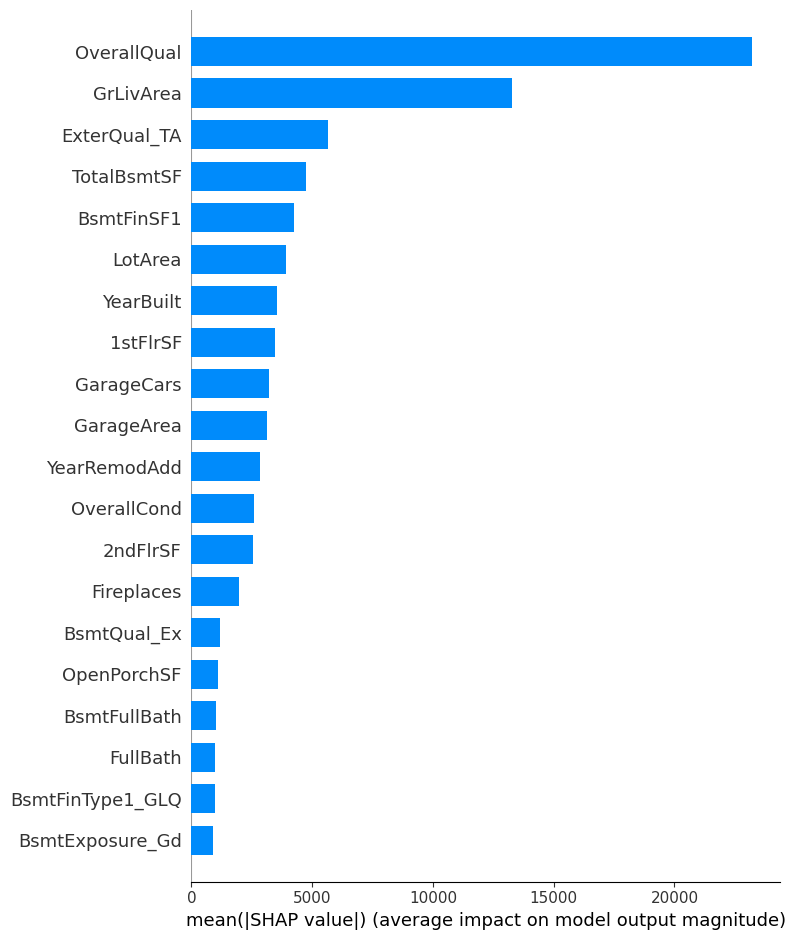

In [12]:
shap.summary_plot(shap_values.values, X_test, plot_type="bar")
